<a href="https://colab.research.google.com/github/Cliffochi/aviva_data_science_course/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###[problem 1] Lagrange's steepest descent by the undetermined multiplier method
Lagrange's undetermined multiplier method is used for SVM learning. Prepare Lagrange multiplier $\lambda$ for the number of samples and update it by the following formula. Implement the method that performs this calculation in the ScratchSVMClassifier class.

In [1]:
import numpy as np

class ScratchSVMClassifier():
    """
    Scratch implementation of SVM classifier (hard margin)

    Parameters
    ----------
    num_iter : int
        Number of iterations
    lr : float
        Learning rate
    kernel : str
        Kernel type ('linear' only in this implementation)
    threshold : float
        Threshold for choosing a support vector
    verbose : bool
        True to output the learning process
    """

    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False):
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.lam = None  # Lagrange multipliers
        self.X_sv = None  # Support vectors
        self.y_sv = None  # Support vector labels
        self.lam_sv = None  # Support vector multipliers

    def _linear_kernel(self, x1, x2):
        """Linear kernel function"""
        return np.dot(x1, x2)

    def fit(self, X, y):
        """
        Train SVM classifier using gradient ascent on Lagrange multipliers

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Training features
        y : ndarray, shape (n_samples,)
            Training labels (-1 or 1)
        """
        n_samples, n_features = X.shape

        # Initialize Lagrange multipliers
        self.lam = np.zeros(n_samples)

        # Gradient ascent
        for _ in range(self.iter):
            for i in range(n_samples):
                # Calculate update term
                update = 0
                for j in range(n_samples):
                    if self.kernel == 'linear':
                        k = self._linear_kernel(X[i], X[j])
                    update += self.lam[j] * y[i] * y[j] * k

                # Update Lagrange multiplier
                self.lam[i] += self.lr * (1 - update)

                # Enforce non-negativity constraint
                self.lam[i] = max(0, self.lam[i])

        # Identify support vectors (non-zero lambdas)
        sv_indices = np.where(self.lam > self.threshold)[0]
        self.X_sv = X[sv_indices]
        self.y_sv = y[sv_indices]
        self.lam_sv = self.lam[sv_indices]
        self.n_support_vectors = len(sv_indices)

        if self.verbose:
            print(f"Found {self.n_support_vectors} support vectors")

    def predict(self, X):
        """
        Predict class labels using trained SVM

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Input features

        Returns
        -------
        ndarray, shape (n_samples,)
            Predicted class labels (-1 or 1)
        """
        y_pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            score = 0
            for j in range(self.n_support_vectors):
                if self.kernel == 'linear':
                    k = self._linear_kernel(X[i], self.X_sv[j])
                score += self.lam_sv[j] * self.y_sv[j] * k
            y_pred[i] = np.sign(score)
        return y_pred

###[problem 2] Support vector determination
A sample whose Lagrange multiplier calculated $ \ lambda $ is larger than the Settings threshold is treated as a support vector. You will need a support vector when estimating. Write the code to determine the support vector and keep it as an instance variable.

The threshold is a hyperparameter, but it is a good idea to start with about 1e-5. If you can output the number of support vectors, you can check whether the learning is done well.

In [2]:
class ScratchSVMClassifier():
    """
    Scratch implementation of SVM classifier (hard margin)

    Parameters
    ----------
    num_iter : int
        Number of iterations
    lr : float
        Learning rate
    threshold : float
        Threshold for choosing a support vector (default: 1e-5)
    verbose : bool
        True to output the learning process
    """

    def __init__(self, num_iter, lr, threshold=1e-5, verbose=False):
        self.iter = num_iter
        self.lr = lr
        self.threshold = threshold
        self.verbose = verbose

        # Support vector attributes
        self.n_support_vectors = 0
        self.index_support_vectors = None
        self.X_sv = None  # Support vector features
        self.lam_sv = None  # Support vector multipliers
        self.y_sv = None  # Support vector labels

        # Internal variables
        self.lam = None  # All Lagrange multipliers

    def _identify_support_vectors(self, X, y):
        """
        Identify and store support vectors based on Lagrange multipliers
        """
        sv_indices = np.where(self.lam > self.threshold)[0]
        self.n_support_vectors = len(sv_indices)
        self.index_support_vectors = sv_indices
        self.X_sv = X[sv_indices]
        self.y_sv = y[sv_indices]
        self.lam_sv = self.lam[sv_indices]

        if self.verbose:
            print(f"Identified {self.n_support_vectors} support vectors")
            print(f"Support vector indices: {sv_indices}")
            print(f"Support vector multipliers: {self.lam_sv}")

    def fit(self, X, y):
        """
        Train SVM classifier and identify support vectors
        """
        n_samples = X.shape[0]
        self.lam = np.zeros(n_samples)

        # Gradient ascent to optimize Lagrange multipliers
        for iteration in range(self.iter):
            for i in range(n_samples):
                # Calculate the update term
                update = 0
                for j in range(n_samples):
                    update += self.lam[j] * y[i] * y[j] * np.dot(X[i], X[j])

                # Update with learning rate and enforce non-negativity
                self.lam[i] += self.lr * (1 - update)
                self.lam[i] = max(0, self.lam[i])

        # Identify support vectors after training
        self._identify_support_vectors(X, y)

        if self.verbose:
            print(f"Final Lagrange multipliers: {self.lam}")

    def predict(self, X):
        """
        Predict using support vectors
        """
        y_pred = np.zeros(X.shape[0])

        for i in range(X.shape[0]):
            score = 0
            for j in range(self.n_support_vectors):
                # Only use support vectors for prediction
                kernel = np.dot(X[i], self.X_sv[j])
                score += self.lam_sv[j] * self.y_sv[j] * kernel
            y_pred[i] = np.sign(score)

        return y_pred

###Notes:

- Support Vector Identification:

Stores indices, features, labels, and multipliers of support vectors

Uses the threshold (default: 1e-5) to determine which samples are support vectors

Accessible via instance variables after fitting:
svm.X_sv  # Support vector features
svm.y_sv  # Support vector labels
svm.lam_sv  # Support vector multipliers

- Verbose Output:

Reports number of support vectors found

Shows their indices and multiplier values

Helps debug learning process

- Prediction Optimization:

Only uses support vectors (not all training data) for predictions

More efficient than using full training set

###[Problem 3]Estimated
At the time of estimation, the features of the data to be estimated and the features of the support vector are calculated using a kernel function. The sign of $f(x)$ obtained is the classification result.

In [3]:
def predict(self, X):
    """
    Predict class labels using support vectors and kernel function

    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
        Input features to predict

    Returns
    -------
    ndarray, shape (n_samples,)
        Predicted class labels (-1 or 1)
    """
    n_samples = X.shape[0]
    y_pred = np.zeros(n_samples)

    for i in range(n_samples):
        f_x = 0  # Decision function value

        # Sum over all support vectors
        for n in range(self.n_support_vectors):
            if self.kernel == 'linear':
                # Linear kernel: K(x, s_n) = x.T @ s_n
                kernel_val = np.dot(X[i], self.X_sv[n])

            f_x += self.lam_sv[n] * self.y_sv[n] * kernel_val

        # Apply sign function to get class prediction
        y_pred[i] = np.sign(f_x)

    return y_pred

##Verification

###【problem 4】Learning and estimation
Learn and estimate the scratch implementation for the binary classification of Simple Dataset 1 prepared in the Sprint, an introduction to machine learning scratch.

Compare this with the scikit-learn implementation and see if it works correctly.

Use scikit-learn for indicator values ​​such as Accuracy, Precision and Recall.

In [9]:
import numpy as np

class ScratchSVMClassifier():
    """
    Scratch implementation of SVM classifier (hard margin)

    Parameters
    ----------
    num_iter : int
        Number of iterations
    lr : float
        Learning rate
    kernel : str
        Kernel type ('linear' only in this implementation)
    threshold : float
        Threshold for choosing a support vector
    verbose : bool
        True to output the learning process
    """

    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False):
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.lam = None  # Lagrange multipliers
        self.X_sv = None  # Support vectors
        self.y_sv = None  # Support vector labels
        self.lam_sv = None  # Support vector multipliers

        # Support vector attributes
        self.n_support_vectors = 0
        self.index_support_vectors = None  # Support vector features


    def _linear_kernel(self, x1, x2):
        """Linear kernel function"""
        return np.dot(x1, x2)

    def _identify_support_vectors(self, X, y):
        """
        Identify and store support vectors based on Lagrange multipliers
        """
        sv_indices = np.where(self.lam > self.threshold)[0]
        self.n_support_vectors = len(sv_indices)
        self.index_support_vectors = sv_indices
        self.X_sv = X[sv_indices]
        self.y_sv = y[sv_indices]
        self.lam_sv = self.lam[sv_indices]

        if self.verbose:
            print(f"Identified {self.n_support_vectors} support vectors")
            print(f"Support vector indices: {sv_indices}")
            print(f"Support vector multipliers: {self.lam_sv}")

    def fit(self, X, y):
        """
        Train SVM classifier using gradient ascent on Lagrange multipliers

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Training features
        y : ndarray, shape (n_samples,)
            Training labels (-1 or 1)
        """
        n_samples, n_features = X.shape

        # Initialize Lagrange multipliers
        self.lam = np.zeros(n_samples)

        # Gradient ascent
        for _ in range(self.iter):
            for i in range(n_samples):
                # Calculate update term
                update = 0
                for j in range(n_samples):
                    if self.kernel == 'linear':
                        k = self._linear_kernel(X[i], X[j])
                    update += self.lam[j] * y[i] * y[j] * k

                # Update Lagrange multiplier
                self.lam[i] += self.lr * (1 - update)

                # Enforce non-negativity constraint
                self.lam[i] = max(0, self.lam[i])

        # Identify support vectors (non-zero lambdas)
        self._identify_support_vectors(X, y)

        if self.verbose:
            print(f"Found {self.n_support_vectors} support vectors")

    def predict(self, X):
        """
        Predict class labels using trained SVM

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Input features

        Returns
        -------
        ndarray, shape (n_samples,)
            Predicted class labels (-1 or 1)
        """
        y_pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            score = 0
            for j in range(self.n_support_vectors):
                if self.kernel == 'linear':
                    k = self._linear_kernel(X[i], self.X_sv[j])
                score += self.lam_sv[j] * self.y_sv[j] * k
            y_pred[i] = np.sign(score)
        return y_pred

In [10]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Load and prepare Iris dataset (binary classification: setosa vs versicolor)
iris = load_iris()
X = iris.data[:100]  # Use only setosa (0-50) and versicolor (50-100)
y = np.where(iris.target[:100] == 0, 1, -1)  # Convert to 1 (setosa) and -1 (versicolor)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Train scratch implementation
scratch_svm = ScratchSVMClassifier(num_iter=1000, lr=0.01, threshold=1e-5, verbose=True)
scratch_svm.fit(X_train_scaled, y_train)

# 2. Train scikit-learn implementation (linear kernel, hard margin)
sklearn_svm = SVC(kernel='linear', C=1e10)  # Large C ≈ hard margin
sklearn_svm.fit(X_train_scaled, y_train)

# Predictions
scratch_pred = scratch_svm.predict(X_test_scaled)
sklearn_pred = sklearn_svm.predict(X_test_scaled)

# Evaluation metrics
def print_metrics(name, y_true, y_pred):
    print(f"\n{name} SVM Performance:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label=1):.4f}")

print_metrics("Scratch", y_test, scratch_pred)
print_metrics("Scikit-learn", y_test, sklearn_pred)

# Compare support vectors
print("\nSupport Vector Comparison:")
print(f"Scratch SVM: {scratch_svm.n_support_vectors} support vectors")
print(f"Scikit-learn: {len(sklearn_svm.support_vectors_)} support vectors")

# Compare coefficients (for linear kernel)
if scratch_svm.kernel == 'linear' and sklearn_svm.kernel == 'linear':
    print("\nWeight Vector Comparison:")
    print("Scratch SVM weights (manual calculation):")
    w_scratch = np.sum(scratch_svm.lam_sv.reshape(-1,1) * scratch_svm.y_sv.reshape(-1,1) * scratch_svm.X_sv, axis=0)
    print(w_scratch)

    print("Scikit-learn weights:")
    print(sklearn_svm.coef_[0])

Identified 3 support vectors
Support vector indices: [51 54 55]
Support vector multipliers: [0.47038997 0.70105345 0.23240442]
Found 3 support vectors

Scratch SVM Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000

Scikit-learn SVM Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000

Support Vector Comparison:
Scratch SVM: 3 support vectors
Scikit-learn: 4 support vectors

Weight Vector Comparison:
Scratch SVM weights (manual calculation):
[-0.09729548  0.41795885 -0.64969304 -0.88779331]
Scikit-learn weights:
[-0.26207387  0.32949008 -0.68238082 -0.74210926]


###[problem5] Visualization of decision area
Visualize the decision area.

Identified 8 support vectors
Support vector indices: [ 1 12 16 51 54 55 59 61]
Support vector multipliers: [1.88310931 3.15149571 1.88040049 4.69929233 0.47095182 4.0855177
 4.87227069 9.66804335]
Found 8 support vectors


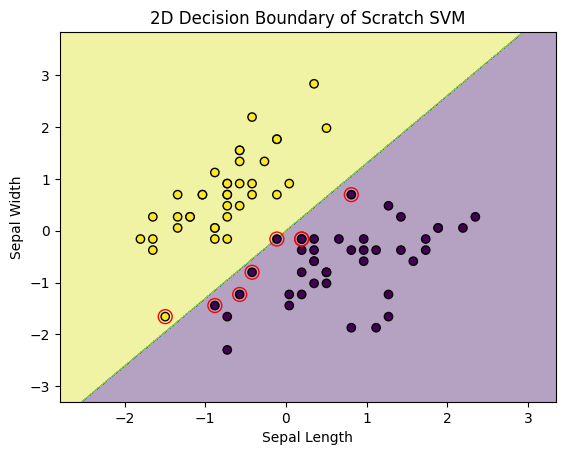

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Use ONLY 2 features for plotting
X_train_2d = X_train_scaled[:, :2]
scratch_svm.fit(X_train_2d, y_train)  # Retrain on 2D data

# Create meshgrid
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict and plot
Z = scratch_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, edgecolors='k')
plt.scatter(scratch_svm.X_sv[:, 0], scratch_svm.X_sv[:, 1],
            s=100, facecolors='none', edgecolors='r')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.title('2D Decision Boundary of Scratch SVM')
plt.show()

##Implementation of other kernel functions
【problem 6】(Advance task) Creation of polynomial kernel function

The first implementation I created used a linear kernel. Let's also switch to the polynomial kernel.

In [23]:
import numpy as np
def _polynomial_kernel(self, x1, x2, gamma, theta0, d):
        """Polynomial kernel function"""
        return (gamma * np.dot(x1, x2) + theta0)**d

def fit(self, X, y, gamma=1, theta0=0, d=1):
        """
        Train SVM classifier using gradient ascent on Lagrange multipliers

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Training features
        y : ndarray, shape (n_samples,)
            Training labels (-1 or 1)
        gamma: float
          Hyperparameter of polynomial kernel
        theta0: float
          Hyperparameter of polynomial kernel
        d: int
          Hyperparameter of polynomial kernel
        """
        n_samples, n_features = X.shape

        # Initialize Lagrange multipliers
        self.lam = np.zeros(n_samples)

        # Gradient ascent
        for _ in range(self.iter):
            for i in range(n_samples):
                # Calculate update term
                update = 0
                for j in range(n_samples):
                    if self.kernel == 'linear':
                        k = self._linear_kernel(X[i], X[j])
                    elif self.kernel == 'polynomial':
                        k = self._polynomial_kernel(X[i],X[j],gamma, theta0, d)
                    update += self.lam[j] * y[i] * y[j] * k

                # Update Lagrange multiplier
                self.lam[i] += self.lr * (1 - update)

                # Enforce non-negativity constraint
                self.lam[i] = max(0, self.lam[i])

        # Identify support vectors (non-zero lambdas)
        self._identify_support_vectors(X, y)

        if self.verbose:
            print(f"Found {self.n_support_vectors} support vectors")

def predict(self, X, gamma=1, theta0=0, d=1):
        """
        Predict class labels using trained SVM

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Input features
        gamma: float
          Hyperparameter of polynomial kernel
        theta0: float
          Hyperparameter of polynomial kernel
        d: int
          Hyperparameter of polynomial kernel

        Returns
        -------
        ndarray, shape (n_samples,)
            Predicted class labels (-1 or 1)
        """
        y_pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            score = 0
            for j in range(self.n_support_vectors):
                if self.kernel == 'linear':
                    k = self._linear_kernel(X[i], self.X_sv[j])
                elif self.kernel == 'polynomial':
                    k = self._polynomial_kernel(X[i], self.X_sv[j], gamma, theta0, d)
                score += self.lam_sv[j] * self.y_sv[j] * k
            y_pred[i] = np.sign(score)
        return y_pred
